In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy as bce
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

### Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[:,:,:,tf.newaxis]
x_test = x_test[:,:,:,tf.newaxis]

### Model

In [3]:
batch_size = 100
original_dim = 28 * 28
latent_dim = 128
epochs = 50
epsilon_std = 1.0
img_height = 28
img_width = 28
no_channels = 1

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape = (batch_size, latent_dim), mean = 0., stddev = epsilon_std)
    return z_mean + tf.math.exp(z_log_var / 2) * epsilon

In [5]:
input_img = Input(shape=(img_height, img_width, no_channels), name="input")
x = Conv2D(32, 3, padding = 'same', activation = 'relu', name="conv-1")(input_img)
x = Conv2D(32, 3, padding = 'same', activation = 'relu', strides = (2, 2), name="conv-2")(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv-1 (Conv2D)                (None, 28, 28, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv-2 (Conv2D)                (None, 14, 14, 32)   9248        ['conv-1[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['conv-2[0][0]']                 
                                                                                            

In [6]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(14 * 14 * 32, activation='relu')(x)
x = Reshape((14, 14, 32))(x)
x = Dropout(0.25)(x)
x = Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2), name="convtranspose-1")(x)
output = Conv2DTranspose(1, 3, padding = 'same', activation = 'sigmoid', name="convtranspose-2")(x)
decoder = Model(latent_inputs, output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 reshape (Reshape)           (None, 14, 14, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 convtranspose-1 (Conv2DTran  (None, 28, 28, 32)       9248      
 spose)                                                          
                                                           

In [7]:
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 128),             845536    
                              (None, 128),                       
                              (100, 128)]                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         835137    
                                                                 
Total params: 1,680,673
Trainable params: 1,680,673
Non-trainable params: 0
_________________________________________________________________


In [8]:
xent_loss = original_dim * bce(axis = [1,2], reduction=tf.keras.losses.Reduction.NONE)(input_img, outputs)
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis = -1)
vae.add_loss(xent_loss + kl_loss)
vae.compile(optimizer = 'Adam')
history = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = [x_test, x_test])

Epoch 1/50
600/600 [==============================] - 11s 13ms/step - loss: 186.2601 - val_loss: 152.7639
Epoch 2/50
600/600 [==============================] - 7s 12ms/step - loss: 146.7495 - val_loss: 135.4678
Epoch 3/50
600/600 [==============================] - 7s 12ms/step - loss: 134.2635 - val_loss: 125.3119
Epoch 4/50
600/600 [==============================] - 7s 12ms/step - loss: 126.0366 - val_loss: 118.5247
Epoch 5/50
600/600 [==============================] - 7s 12ms/step - loss: 120.9705 - val_loss: 114.4231
Epoch 6/50
600/600 [==============================] - 8s 13ms/step - loss: 117.8923 - val_loss: 112.4430
Epoch 7/50
600/600 [==============================] - 7s 12ms/step - loss: 115.7411 - val_loss: 111.1286
Epoch 8/50
600/600 [==============================] - 7s 12ms/step - loss: 114.3363 - val_loss: 110.1165
Epoch 9/50
600/600 [==============================] - 8s 13ms/step - loss: 113.3737 - val_loss: 109.8660
Epoch 10/50
600/600 [==============================] -

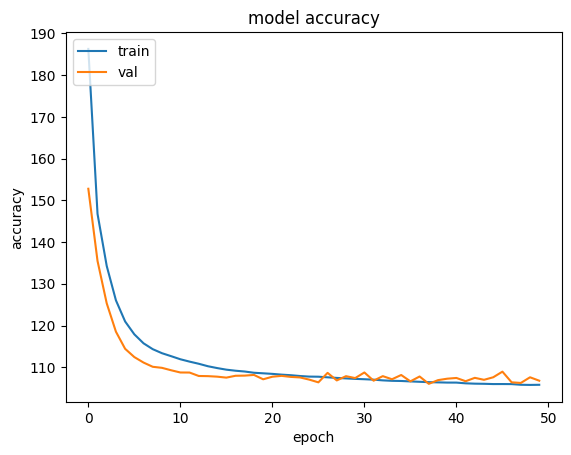

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Predictions

313/313 [==============================] - 1s 2ms/step


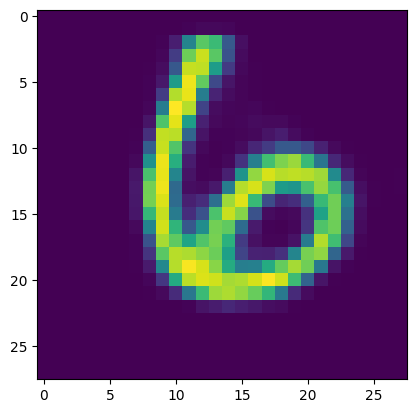

In [17]:
test = encoder.predict(x_test, batch_size = batch_size)
results = decoder.predict(test[2])
plt.imshow(results[100,:,:,0])

### Generating

In [10]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

with tqdm(total=len(grid_x) * len(grid_y)) as pbar:
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose = 0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            pbar.update(1)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

  0%|                                                                                          | 0/225 [00:00<?, ?it/s]


ValueError: in user code:

    File "C:\Users\ttummpa\Miniconda3\envs\s9\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ttummpa\Miniconda3\envs\s9\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ttummpa\Miniconda3\envs\s9\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ttummpa\Miniconda3\envs\s9\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\ttummpa\Miniconda3\envs\s9\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ttummpa\Miniconda3\envs\s9\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 128), found shape=(None, 2)
